In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressiony


In [7]:
from io import BytesIO
import requests
import tarfile

url = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

def load_imdb_dataset(extract_path='../../../mlcourse_data/', overwrite=False):
    if os.path.isfile(os.path.join(extract_path, "acImdb", 'README')) and not overwrite:
        print('IMDB data is already in place')
        return
    
    print("Downloading dataset from ", url)
    response = requests.get(url)
    
    tar = tarfile.open(mode='r:gz', fileobj=BytesIO(response.content))
    
    data = tar.extractall(extract_path)

load_imdb_dataset()

## IMDB dataset

In [8]:
PATH_TO_IMDB = '../../../mlcourse_data/aclImdb'

reviews_train = load_files(os.path.join(PATH_TO_IMDB, "train"), categories=['pos', 'neg'])

text_train, y_train = reviews_train.data, reviews_train.target

reviews_test = load_files(os.path.join(PATH_TO_IMDB, "test"), categories=['pos', 'neg'])
text_test, y_test = reviews_test.data, reviews_test.target

In [14]:
np.shape(text_train)

(25000,)

In [21]:
print("Number of documents in the training data: {}".format(len(text_train)))
print(np.bincount(y_train))
print("Number of documents in the test data: {}".format(len(text_test)))
print(np.bincount(y_test))

Number of documents in the training data: 25000
[12500 12500]
Number of documents in the test data: 25000
[12500 12500]


In [18]:
print(text_train[5])

b"The Movie was sub-par, but this Television Pilot delivers a great springboard into what has become a Sci-Fi fans Ideal program. The Actors deliver and the special effects (for a television series) are spectacular. Having an intelligent interesting script doesn't hurt either.<br /><br />Stargate SG1 is currently one of my favorite programs."


In [19]:
print(y_train[5])

1


## Bag of Words

### CountVectorizer

In [24]:
cv = CountVectorizer()
X_train = cv.fit_transform(text_train)
X_train


<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3445861 stored elements in Compressed Sparse Row format>

In [23]:
print(len(cv.vocabulary_))

print(cv.get_feature_names()[:50])
print(cv.get_feature_names()[50000:500050])

74849
['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02', '020410', '029', '03', '04', '041', '05', '050', '06', '06th', '07', '08', '087', '089', '08th', '09', '0f', '0ne', '0r', '0s', '10', '100', '1000', '1000000', '10000000000000', '1000lb', '1000s', '1001', '100b', '100k', '100m']
['pincher', 'pinchers', 'pinches', 'pinching', 'pinchot', 'pinciotti', 'pine', 'pineal', 'pineapple', 'pineapples', 'pines', 'pinet', 'pinetrees', 'pineyro', 'pinfall', 'pinfold', 'ping', 'pingo', 'pinhead', 'pinheads', 'pinho', 'pining', 'pinjar', 'pink', 'pinkerton', 'pinkett', 'pinkie', 'pinkins', 'pinkish', 'pinko', 'pinks', 'pinku', 'pinkus', 'pinky', 'pinnacle', 'pinnacles', 'pinned', 'pinning', 'pinnings', 'pinnochio', 'pinnocioesque', 'pino', 'pinocchio', 'pinochet', 'pinochets', 'pinoy', 'pinpoint', 'pinpoints', 'pins', 'pinsent', 'pint', 'pinta', 'pinter', 'pintilie', 'pinto', 'pint

In [35]:
X_test = cv.transform(text_test)

### Traininig Logistic Regression

In [38]:
%%time
C = 1
logit = LogisticRegression(C=C, random_state=7, solver='lbfgs', n_jobs=-1)
logit.fit(X_train, y_train)

Wall time: 22 s


In [40]:
print(round(logit.score(X_train, y_train), 3), round(logit.score(X_test, y_test), 3))

0.981 0.864


In [54]:
def visualize_coeffs(clf, feature_names, n_top_feats=25):
    coef = clf.coef_.ravel()
    pos_coeffs = np.argsort(coef)[-n_top_feats:]
    neg_coeffs = np.argsort(coef)[:n_top_feats]
    interesting_coeffs = np.hstack([neg_coeffs, pos_coeffs])
    
    plt.figure(figsize=(15,5))
    colors = ['red' if c<0 else 'blue' for c in coef[interesting_coeffs]]
    plt.bar(np.arange(2*n_top_feats), coef[interesting_coeffs], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1+2*n_top_feats), feature_names[interesting_coeffs], rotation=60, ha='right');

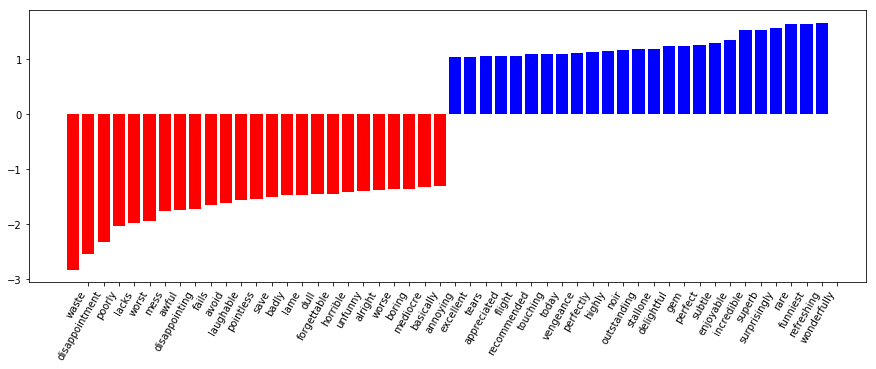

In [55]:
visualize_coeffs(logit, cv.get_feature_names())

In [57]:
def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'], color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'], color='blue', label='test')
    plt.legend();

## Cross-Validation

In [59]:
from sklearn.pipeline import make_pipeline

text_pipe_logit = make_pipeline(CountVectorizer(), LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=17))

text_pipe_logit.fit(text_train, y_train)
print(text_pipe_logit.score(text_test, y_test))

0.86396


In [60]:
from sklearn.model_selection import GridSearchCV

In [62]:
%%time

param_grid_logit = {'logisticregression__C': np.logspace(-5, 0, 6)}

grid_logit = GridSearchCV(text_pipe_logit, param_grid_logit, return_train_score=True, cv=3, n_jobs=-1)

grid_logit.fit(text_train, y_train)

Wall time: 2min 28s


In [64]:
grid_logit.best_params_, grid_logit.best_score_

({'logisticregression__C': 0.1}, 0.8848)

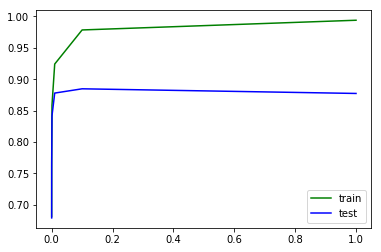

In [65]:
plot_grid_scores(grid_logit, 'logisticregression__C')

In [67]:
grid_logit.score(text_test, y_test)

0.87812

In [68]:
from sklearn.ensemble import RandomForestClassifier

In [69]:
rf = RandomForestClassifier(random_state=7, n_estimators=200, n_jobs=-1)

In [70]:
%%time
rf.fit(X_train, y_train)

Wall time: 1min 27s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=7, verbose=0, warm_start=False)

In [72]:
round(rf.score(X_test, y_test), 3)

0.854